In [144]:
#coding utf8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers, metrics
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import svm
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.feature_selection import mutual_info_regression, f_regression, r_regression
import sklearn
from sklearn.ensemble import RandomForestRegressor
import matplotlib.dates as mdates
#from PyIF import te_compute as te
#from neuralprophet import NeuralProphet


In [2]:
'''
Functions for loading in and combining data
'''
def load_df(file_name, sheet = 'Sheet 1'):
    '''
    Load a file into a data frame that is quarterly from the Eurostat website
    '''
    df = pd.read_excel(file_name, sheet_name=sheet)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df.replace(':', np.nan, inplace=True)
    df.index = df.iloc[:, 0]
    df.drop(df.columns[[0]], axis=1, inplace=True)
    for i in df.columns[:]:
        df[i] = df[i].apply(pd.to_numeric, errors="coerce")
    df.interpolate(method='linear', inplace=True, axis = 1)
    df.sort_index(inplace=True)
    df = df.rename({'Germany (until 1990 former territory of the FRG)': 'Germany'})
    return df

def create_per_employeer(GDP_df, HW_df, employees_df):
    ''' 
    Inputs: GDP, hours worked, and employees dataframes
    Output: dataframe with per-employee GDP and per hour worked GDP
    '''
    cols =(list(set(GDP_df.columns) and set(employees_df.columns) and set(HW_df.columns)))
    cols.sort()
    idx = cols.pop()
    per_employee_df = pd.DataFrame(index=GDP_df.index, columns=cols)
    per_HW_df = pd.DataFrame(index=GDP_df.index, columns=cols)
    for i in cols:
        per_employee_df[i] = GDP_df[i]/employees_df[i]
        per_HW_df[i] = per_employee_df[i]/HW_df[i]
    return per_employee_df, per_HW_df

def country_code_to_name(df):
    '''
    Renames country codes to country names
    '''
    df = df.rename({'AUT': 'Austria', 'BEL': 'Belgium', 'DEU': 'Germany','EST': 'Estonia','FIN': 'Finland','ESP': 'Spain','FRA': 'France','GRC': 'Greece','IRL': 'Ireland','ITA': 'Italy','LTU': 'Lithuania','LUX': 'Luxembourg','LVA': 'Latvia','PRT': 'Portugal','NLD': 'Netherlands','SVK': 'Slovakia','SVN': 'Slovenia','ISL': 'Iceland','GBR': 'United Kingdom','CHE': 'Switzerland','CZE': 'Cezch Republic','DNK': 'Denmark','HUN': 'Hungary','NOR': 'Norway','POL': 'Poland','SWE': 'Sweden'})
    return df

def yearly_to_quarterly(df):
    '''
    Inputs: df
    Converts the data from yearly to quarterly
    Outputs: quarterly_df
    '''
    data = df.to_numpy(dtype=np.float64)
    data = np.repeat(data, 4, axis = 1)
    quarterly_df = pd.DataFrame(data)
    quarterly_df.index = df.index
    quarterly_df.columns = GDP_df.columns[(int(df.columns[0]) - 1975)*4:(int(df.columns[-1]) - 2021)*4]
    return quarterly_df

def match_df(dfs):
    ''' 
    Input : dataframes
    This function matches dataframes by their index and column 
    Output: matched dataframes
    '''
    idx = set(dfs[0].index)
    cols = set(dfs[0].columns)
    for i in dfs:
        idx = idx.intersection(set(i.index))
        cols = cols.intersection(set(i.columns))
    cols = list(cols)
    idx = list(idx)
    cols.sort()
    idx.sort()
    for i in range(len(dfs)):
        dfs[i] = dfs[i].loc[idx]
        dfs[i] = dfs[i][cols]
    return dfs

def to_datetime(df):
    df.columns = [w.replace('-Q1','-01') for w in df.columns]
    df.columns = [w.replace('-Q2','-04') for w in df.columns]
    df.columns = [w.replace('-Q3', '-07') for w in df.columns]
    df.columns = [w.replace('-Q4', '-10') for w in df.columns]
    for i in df.columns[:]:
        i = np.datetime64(i)
    df.columns = pd.to_datetime(df.columns)
    return df

def extend_df(dfs):
    idx = set(dfs[0].index)
    cols = set(dfs[0].columns)
    for i in dfs:
        idx = idx.union(set(i.index))
        cols = cols.union(set(i.columns))
    cols = list(cols)
    idx = list(idx)
    cols.sort()
    idx.sort()
    for i in range(len(dfs)):
        dfs[i] = dfs[i].reindex(index=idx, columns=cols)
        dfs[i] = dfs[i].loc[idx]
        dfs[i] = dfs[i][cols]
        dfs[i] = to_datetime(dfs[i])
        dfs[i].interpolate(method='polynomial', order = 5, inplace = True, limit = 100, limit_direction = 'both', axis = 1)
        dfs[i].fillna(0)
    return dfs


In [3]:
'''
Functions for RNN time series prediction
'''
def process_data(X, y, split_point, time_step, data_memory):
    '''
    Inputs: X, y, split_point, time_step, data_memory
    Splits data into training and testing data
    Outputs: X_train, X_test, y_train, y_test
    '''
    X_norm, X_attrs, y_norm, y_attrs = normalise(X, y)
    split_point = int(X_norm.shape[0] *split_point)
    y_norm = np.roll(y_norm, -time_step)
    nrows = X_norm.shape[0]
    samples = X_norm.shape[1]
    X_norm = np.repeat(X_norm, data_memory, 0).reshape(nrows, data_memory, samples)
    x_train, x_test, y_train, y_test = train_test_split(X_norm, y_norm, split_point)
    return x_train, x_test, y_train, y_test, nrows, samples, X_norm, y_norm, X_attrs, y_attrs

def normalise(X, y):
    '''
    Inputs: X, y
    Normalises the data by subtracting the mean and dividing by the standard deviation
    Outputs : X_norm, y_norm, X_attrs, y_attrs
    '''
    X_attrs = np.zeros((X.shape[-1], 2))
    y_attrs = np.zeros((y.shape[-1], 2))
    X_norm = np.zeros(X.shape)
    y_norm = np.zeros(y.shape)
    for i in range(X.shape[-1]):
        X_attrs[i, :] = [np.mean(X[:, i]), np.var(X[:, i])]
        X_norm[:, i] = (X[:, i] - np.mean(X[:, i]))/np.var(X[:, i])**0.5
    for i in range(y.shape[-1]):
        y_attrs[i, :] = [np.mean(y[:, i]), np.var(y[:, i])]
        y_norm[:, i] = (y[:, i] - np.mean(y[:, i]))/np.var(y[:, i])**0.5 
    return X_norm, X_attrs, y_norm, y_attrs

def train_test_split(X, y, split_point):
    '''
    Splits the data into training and testing data
    '''
    x_train = X[:split_point, :, :]
    x_test = X[split_point:, :, :]
    y_train = y[:split_point]
    y_test = y[split_point:]
    return x_train, x_test, y_train, y_test
        
def create_model(layers, input_shape, print_summary):
    '''
    Creates a model with the specified layers
    '''
    model = keras.Sequential(layers)
    model.build(input_shape=input_shape)
    model.compile(loss='mse', optimizer='adam', metrics = [tf.keras.metrics.MeanSquaredError()])
    if print_summary:
        model.summary()
    return model

def run_model(X, y, time_step, data_memory, epochs, batch_size, model_layer, split_point, print_summary=False):
    '''
    Inputs: X, y, time_step, data_memory, epochs, batch_size, model_layer, split_point
    Runs the model on the data
    Outputs: model, history
    '''
    x_train, x_test, y_train, y_test, nrows, samples, X_norm, y_norm, X_attrs, y_attrs = process_data(X, y, split_point, time_step, data_memory)
    input_shape = (x_train.shape[0], data_memory, samples)
    model = create_model(model_layer, input_shape, print_summary)
    history = model.fit(x_train, y_train, validation_split = 0.1, epochs= epochs , batch_size=batch_size)
    y_pred_norm = np.concatenate((model.predict(x_train[:, :, :]), model.predict(x_test[:, :, :])))
    y_pred_norm = np.roll(y_pred_norm, 1, axis = 1)
    y_pred = y_pred_norm *y_attrs[:, 1]**0.5 + y_attrs[:, 0]
    return y_pred, history


In [45]:
'''
Regression stuff
'''

def run_regr(X, y, t, regr):
    regr.fit(X, y)
    nrows = X.shape[0]
    y_reg = np.zeros(nrows)  
    for i in range(nrows):
        y_reg[i] = regr.predict(np.array([X[i, :]]))
    total_loss, loss = cal_loss(y, y_reg, nrows)
    return regr, total_loss, loss, y_reg

def cal_loss(y, y_reg, nrows):
    abs_loss, per_loss = np.zeros(nrows), np.zeros(nrows)
    for i in range(nrows):
        abs_loss[i] = np.abs(y[i] - y_reg[i])
        if y[i] > 0:
            per_loss[i] = abs_loss[i] / y[i]
    total_loss, loss = np.sum(abs_loss)/ nrows, np.sum(per_loss)/ nrows
    return total_loss, loss

In [46]:
'''
Loads in gross domestic product, hours worked and employees data
Returns GDP per employee and GDP per hour worked
'''
GDP_df =  load_df('./data/GDP_per_quarter_2.xlsx') * 1e6
HW_df = load_df('./data/hours_worked.xlsx')
employees_df = load_df('./data/Employees.xlsx') * 1e3
per_employee_df, per_HW_df = create_per_employeer(GDP_df, HW_df, employees_df)

#per_HW_df.iloc[4, :].T.plot(legend = False)

In [156]:
'''
Depression data
'''
dep_df = pd.read_csv('data/depression_by_age.csv') 
dep_df = dep_df.drop(['Prevalence - Depressive disorders - Sex: Both - Age: 10 to 14 (Percent)','Prevalence - Depressive disorders - Sex: Both - Age: All Ages (Percent)','Prevalence - Depressive disorders - Sex: Both - Age: 70+ years (Percent)','Prevalence - Depressive disorders - Sex: Both - Age: Age-standardized (Percent)', 'Prevalence - Depressive disorders - Sex: Both - Age: 15-49 years (Percent)'],axis=1)
a = ['Belgium','Bulgaria','Denmark','Germany','Estonia','Ireland','Greece','Spain','France','Croatia','Italy','Cyprus','Latvia','Lithuania','Luxemburg','Hungary','Malta','Netherlands','Austria','Poland','Portugal','Romania','Slovenia','Slovakia','Finland','Sweden','Iceland','Norway','Switzerland','United Kingdom','Montenegro','North Macedonia','Serbia','Turkey']
dep_df = dep_df[dep_df['Entity'].isin(a)]
dep_df['Age:15-69_depression_average']=dep_df.iloc[:,3:7].mean(axis=1,skipna=True)
dep_df = dep_df.pivot_table('Age:15-69_depression_average', ['Entity', 'Code'], 'Year')
dep_df = dep_df.reset_index('Code')
del dep_df['Code']
dep_quarterly_df = yearly_to_quarterly(dep_df)

'''
Education data
'''
education_dfs = [None] * 4
for i in range(4):
    education_dfs[i] = load_df('./data/Education.xlsx', 'Sheet ' + str(4*i + 1))
    education_dfs[i] = yearly_to_quarterly(education_dfs[i])
    education_dfs[i] = education_dfs[i].rename({'Germany (until 1990 former territory of the FRG)': 'Germany'})
    

'''
Inflation data
'''
inf_df = pd.read_csv('data/Quarterly_infilation.csv')
inf_df =inf_df.drop(['SUBJECT', 'MEASURE','FREQUENCY','Flag Codes'], axis=1)
inf_df = inf_df.pivot_table('Value', ['LOCATION', 'INDICATOR'], 'TIME')
inf_df = country_code_to_name(inf_df)
inf_df = inf_df.reset_index('INDICATOR')
del inf_df['INDICATOR']
inf_df = inf_df.rename({'Germany (until 1990 former territory of the FRG)': 'Germany'})

'''
Unemployment data
'''
unem_df = pd.read_csv('./data/unem.csv')
unem_df.fillna(0)
unem_df = unem_df[['LOCATION', 'TIME', 'Value']]
unem_df = unem_df.pivot_table('Value',  ['LOCATION'],'TIME')
unem_df = country_code_to_name(unem_df)

'''
Combine all dataframes and create a numpy array of the data
Data = [Country, Time, Feature]
'''

dfs = [per_employee_df, per_HW_df] + education_dfs + [inf_df, unem_df, dep_quarterly_df]
matched_dfs = match_df(dfs)
data = np.zeros((len(matched_dfs[0].index), len(matched_dfs[0].columns), len(matched_dfs)))
for i in range(len(matched_dfs)):
    data[:, :, i] = matched_dfs[i].to_numpy(dtype=np.float64)
print(', '.join(matched_dfs[0].index), '\n', ', '.join(matched_dfs[0].columns))

countries = np.concatenate((matched_dfs[0].index[[0, 3, 7, 10, 11, 12]].values, np.array(['EU'])))

dfs = [per_employee_df, per_HW_df] + education_dfs + [inf_df, unem_df, dep_quarterly_df]
extended_dfs = extend_df(dfs)
countries_data = data[[0, 3, 7, 10, 11, 12], :, :]
EU_data = np.average(countries_data,axis=0)
countries_data = np.concatenate((countries_data, np.array([EU_data])), axis=0)
print(countries)

Austria, Belgium, Estonia, Finland, France, Germany, Greece, Ireland, Italy, Latvia, Lithuania, Netherlands, Portugal, Slovenia, Spain 
 2008-Q1, 2008-Q2, 2008-Q3, 2008-Q4, 2009-Q1, 2009-Q2, 2009-Q3, 2009-Q4, 2010-Q1, 2010-Q2, 2010-Q3, 2010-Q4, 2011-Q1, 2011-Q2, 2011-Q3, 2011-Q4, 2012-Q1, 2012-Q2, 2012-Q3, 2012-Q4, 2013-Q1, 2013-Q2, 2013-Q3, 2013-Q4, 2014-Q1, 2014-Q2, 2014-Q3, 2014-Q4, 2015-Q1, 2015-Q2, 2015-Q3, 2015-Q4, 2016-Q1, 2016-Q2, 2016-Q3, 2016-Q4, 2017-Q1, 2017-Q2, 2017-Q3, 2017-Q4, 2018-Q1, 2018-Q2, 2018-Q3, 2018-Q4, 2019-Q1, 2019-Q2, 2019-Q3, 2019-Q4
['Austria' 'Finland' 'Ireland' 'Lithuania' 'Netherlands' 'Portugal' 'EU']


Total Loss:  7.6524399591621135 Loss:  0.012176991530132604


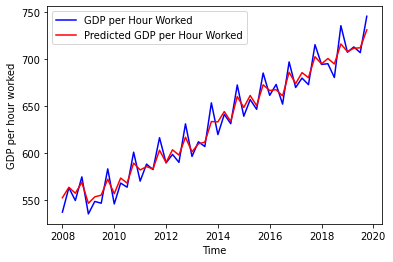

In [71]:

X = data[0, :, 2:]
y = data[0, :, 1]
t = np.linspace(0, y.shape[0], y.shape[0])


regr, total_loss, loss, y_reg = run_regr(X, y, t, RandomForestRegressor())
print('Total Loss: ', total_loss, 'Loss: ', loss)
colours = ['b', 'r']
t = np.arange('2008-01', '2019-12',np.timedelta64(3,'M'), dtype='datetime64')
fig, (ax1) = plt.subplots(1, 1)
ax1.plot(t, y, colours[0], t, y_reg, colours[1])
ax1.set(xlabel='Time', ylabel='GDP per hour worked')
ax1.legend(['GDP per Hour Worked', 'Predicted GDP per Hour Worked'])
plt.savefig('figures/regression.png')

In [ ]:
'''
Attempting to vary values in regression to assess impact on productivity
'''
for i in range(X.shape[1]):
    X = data[0, :, 2:]
    y = data[0, :, 0]
    regr = RandomForestRegressor()
    regr.fit(X, y)
    X[:, i] = X[:, i] *2
    y_pred = regr.predict(X)
    t = np.linspace(0, y.shape[0], y.shape[0])
    total_loss, abs_loss = cal_loss(y, y_pred, t.size)
    print(total_loss, abs_loss)
    colours = ['b', 'r']
    fig, (ax1) = plt.subplots(1, 1)
    ax1.plot(t, y, colours[0], t, y_pred, colours[1])
    ax1.set(xlabel='Time', ylabel='GDP per hour worked')
    ax1.legend(['GDP per hour worked', 'GDP per hour worked predicted'])
plt.savefig('figures/varying_value_regression.png')

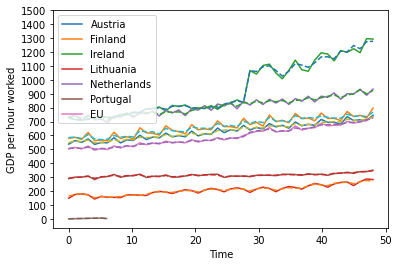

In [158]:
'''
Regression on a variety of countries
'''
y1, y, X = np.split(data[:2,:,:], [1,2], axis=2)
X = countries_data[:, :, 2:]
y = countries_data[:, :, 1]
y = y.reshape(y.shape[0], y.shape[1])
y_reg = np.zeros((y.shape))
loss = np.zeros((y.shape[0], 2))

for i in range(y.shape[0]):
    regr = RandomForestRegressor()
    regr.fit(X[i, :, :], y[i, :])
    y_reg[i, :] = regr.predict(X[i, :, :])
    t = np.linspace(0, y.shape[1], y.shape[1])
    loss[i, :] = cal_loss(y[i, :], y_reg[i, :], t.size)

colours = ['b', 'g', 'k', 'r', 'o', 'y', 'k']

fig, (ax1) = plt.subplots(1, 1)
ax1.plot(t, y.T, colours)
ax1.plot(t, y_reg.T, colours, linestyle = 'dashed')
ax1.set(xlabel='Time', ylabel='GDP per hour worked')
ax1.set(yticks = np.linspace(0, 1500, 16), yticklabels = np.linspace(0, 1500, 16, dtype=int))
ax1.legend(countries)
plt.savefig('figures/countries_regression.png')

In [14]:
'''
Making a dataframe in Neural Prophet format
'''
per_employee_df, per_HW_df = create_per_employeer(GDP_df, HW_df, employees_df)
per_HW_df = to_datetime(per_HW_df)
per_HW_df = per_HW_df.T
per_HW_df.reset_index(inplace=True)
belgium_df = per_HW_df[['index', 'Belgium']].copy()
belgium_df.columns = ['ds', 'y']
belgium_df['ds'] = pd.to_datetime(belgium_df['ds'])
train_df = belgium_df.head(45)
test_df = belgium_df.tail(10)

C:\Apps\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(array([1.        , 0.30070792, 0.31412807, 0.18832811, 0.26918757,
        0.10606819, 0.03363891, 0.17047325]),
 array([1.00000000e+00, 2.13027660e-02, 2.13027660e-02, 2.82153940e-03,
        1.63964235e-02, 2.13257891e-04, 7.78999339e-04, 8.80763774e-03]),
 array([ 1.        , -0.90815698,  0.90815698,  0.61608728,  0.8847625 ,
        -0.20996431, -0.37979531, -0.81097251]))

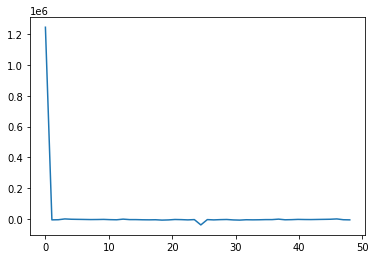

In [120]:
'''
Transfer Entropy
'''
X = data[1, :, 8]
y = data[1, :, 0]
#te.te_compute(X, y, k=1, embedding=1, safetyCheck=True, GPU=False)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.25, random_state=0)
'''
Fourier transform and frequency analysis
'''
y_freq = np.fft.fft(y)
t_freq = np.linspace(0, y.shape[0], y.shape[0])
plt.plot(t_freq, y_freq)
'''
Needs fixing
'''
'''
Mutual information, F-statistic and R-statistic between features and target
'''
X = data[1, :, 1:]
y = data[1, :, 0]
mi = mutual_info_regression(X, y)
mi /= np.max(mi)
f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)
corr = r_regression(X, y)
corr /= np.max(corr)

'''
Display these nicely somehow demonstrating what they mean
'''

mi, f_test, corr

5.900534768933915 0.11960164213776713


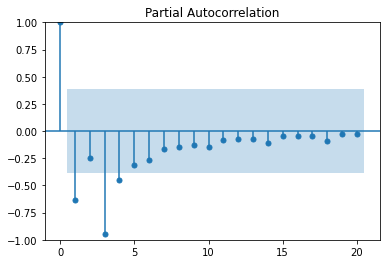

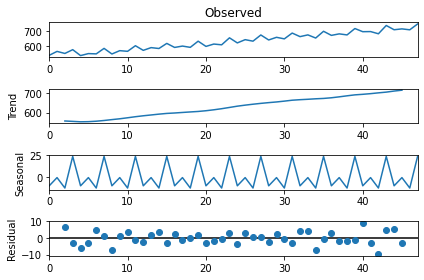

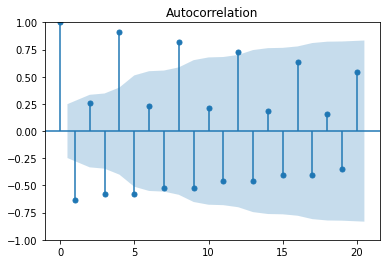

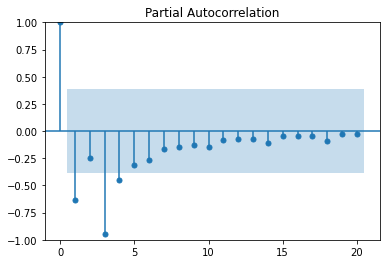

In [142]:
X = countries_data[:, :, 2:]
y = countries_data[:, :, 1]
for i in range(1):
    decomposition = sm.tsa.seasonal_decompose(y[i], model='additive', period=4)
    fig = decomposition.plot()
plt.savefig('figures/seasonal_decomposition.png')
X = data[1, 2:-2, 6:10]
y = decomposition.seasonal[2:-2]
t = np.linspace(0, y.shape[0], y.shape[0])

regr, total_loss, loss, y_pred = run_regr(X, y, t, RandomForestRegressor())
print(total_loss, loss)
plot_acf(y, lags=20, alpha = 0.1)
plot_pacf(y, lags=20, alpha = 0.01, method='ywm')

'\nGet error values and error box plots for the sarima model\n'

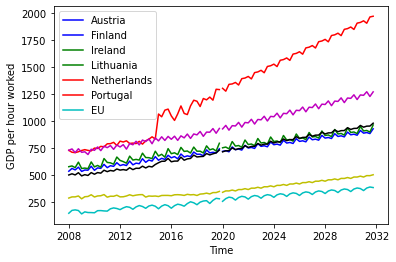

In [160]:
y = data[0, :, 1]

t = np.linspace(0, y.shape[0], y.shape[0])

X = countries_data[:, :, 2:]
y = countries_data[:, :, 1]
fig, (ax1) = plt.subplots(1, 1)
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
y_pred = np.zeros((y.shape))
for i in range(y.shape[0]):
    model = sm.tsa.statespace.SARIMAX(y[i], order=(1, 1, 1), seasonal_order = (1, 1, 1, 4))
    res = model.fit()
    t = np.arange('2008-01', '2031-12',np.timedelta64(3,'M'), dtype='datetime64')
    forecast_values = res.get_forecast(steps=48)
    y_pred[i, :] = forecast_values.predicted_mean
    ax1.plot(t[:48], y[i], colours[i])
    ax1.plot(t[48:], forecast_values.predicted_mean, colours[i])

ax1.legend(countries)
ax1.set(xlabel='Time', ylabel='GDP per hour worked')
plt.savefig('figures/sarima_model.png')


forecast_values.se_mean

'''
Get error values and error box plots for the sarima model
'''


Epoch 1/40
9/9 [==============================] - 4s 68ms/step - loss: 0.4933 - mean_squared_error: 0.4933 - val_loss: 0.5713 - val_mean_squared_error: 0.5713
Epoch 2/40
9/9 [==============================] - 0s 7ms/step - loss: 0.3623 - mean_squared_error: 0.3623 - val_loss: 0.4560 - val_mean_squared_error: 0.4560
Epoch 3/40
9/9 [==============================] - 0s 8ms/step - loss: 0.3031 - mean_squared_error: 0.3031 - val_loss: 0.4015 - val_mean_squared_error: 0.4015
Epoch 4/40
9/9 [==============================] - 0s 7ms/step - loss: 0.2900 - mean_squared_error: 0.2900 - val_loss: 0.3782 - val_mean_squared_error: 0.3782
Epoch 5/40
9/9 [==============================] - 0s 7ms/step - loss: 0.2440 - mean_squared_error: 0.2440 - val_loss: 0.3684 - val_mean_squared_error: 0.3684
Epoch 6/40
9/9 [==============================] - 0s 8ms/step - loss: 0.2209 - mean_squared_error: 0.2209 - val_loss: 0.3623 - val_mean_squared_error: 0.3623
Epoch 7/40
9/9 [==============================] - 0

'\nFix the RNN by adding more data from the past to train on and the future stepping thing is correct \n'

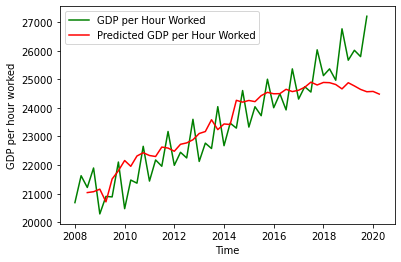

In [24]:
'''
RNN on the data
'''
time_step, data_memory, epochs, batch_size, split_point = 5, 8, 40, 4, 0.8

load_model_bool, load_model, save_model, save_fig = False, 'EU_model', 'EU_model', 'EU'
model_layer = [layers.GRU(16,activation= 'tanh', dropout = 0.1, recurrent_dropout = 0.1, return_sequences=False),
                layers.Dense(2)]

X = data[0, :, 2:]
y = data[0, :, 0:1]
t = np.linspace(0, y.shape[0], y.shape[0])
y_pred, history = run_model(X, y, time_step, data_memory, epochs, batch_size, model_layer, split_point)

t = np.arange('2008-01', '2020-07',np.timedelta64(3,'M'), dtype='datetime64')
fig, (ax1) = plt.subplots(1, 1)
plt.plot( t[:48], y, 'g', t[time_step - 3:], y_pred[:, 0], 'r')
ax1.set(xlabel='Time', ylabel='GDP per hour worked')
ax1.legend(['GDP per Hour Worked', 'Predicted GDP per Hour Worked'])
plt.savefig('figures/rnn_model.png')
train_loss = history.history['loss']
val_loss = history.history['val_loss']
print(train_loss[-1], val_loss[-1])


'''
Fix the RNN by adding more data from the past to train on and the future stepping thing is correct 
'''

Epoch 1/40
8/8 [==============================] - 4s 54ms/step - loss: 0.8942 - mean_squared_error: 0.8942 - val_loss: 1.2934 - val_mean_squared_error: 1.2934
Epoch 2/40
8/8 [==============================] - 0s 8ms/step - loss: 0.7220 - mean_squared_error: 0.7220 - val_loss: 1.1165 - val_mean_squared_error: 1.1165
Epoch 3/40
8/8 [==============================] - 0s 8ms/step - loss: 0.6055 - mean_squared_error: 0.6055 - val_loss: 0.9526 - val_mean_squared_error: 0.9526
Epoch 4/40
8/8 [==============================] - 0s 13ms/step - loss: 0.5055 - mean_squared_error: 0.5055 - val_loss: 0.8073 - val_mean_squared_error: 0.8073
Epoch 5/40
8/8 [==============================] - 0s 9ms/step - loss: 0.3953 - mean_squared_error: 0.3953 - val_loss: 0.6841 - val_mean_squared_error: 0.6841
Epoch 6/40
8/8 [==============================] - 0s 9ms/step - loss: 0.3231 - mean_squared_error: 0.3231 - val_loss: 0.5676 - val_mean_squared_error: 0.5676
Epoch 7/40
8/8 [==============================] - 

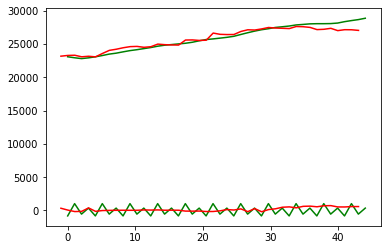

In [25]:
'''
RNN on the decomposed data
'''
time_step, data_memory, epochs, batch_size, split_point = 1, 8, 40, 4, 0.8

load_model_bool, load_model, save_model, save_fig = False, 'EU_model', 'EU_model', 'EU'
model_layer = [layers.Dense(8, activation= 'linear'),
                layers.LSTM(16,activation= 'tanh', dropout = 0.1, recurrent_dropout = 0.1, return_sequences=False),
                layers.Dense(2)]
print_summary = True
X = data[0, :, 2:]

y = data[0, :, 0:1]
X = data[1, 2:-2, 2:]
y = np.array([decomposition.trend[2:-2]]).T
t = np.linspace(0, y.shape[0], y.shape[0])
y_pred, history = run_model(X, y, time_step, data_memory, epochs, batch_size, model_layer, split_point)

plt.plot(t, y, 'g', t + time_step - 2, y_pred[:, 0], 'r')
train_loss = history.history['loss']
val_loss = history.history['val_loss']

y = np.array([decomposition.seasonal[2:-2]]).T
y_pred, history = run_model(X, y, time_step, data_memory, epochs, batch_size, model_layer, split_point)
plt.plot(t, y, 'g', t + time_step - 2, y_pred[:, 0], 'r')
plt.savefig('figures/rnn_time_decomposed_model.png')

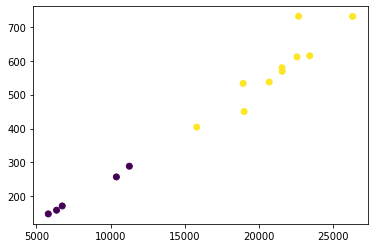

In [26]:
'''
Clustering of features using K-means

X = [Country, Time, Features]
Plot the clusters against properties
'''
X = data[:, 0, :]
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
plt.scatter(X[:, 0], X[:, 1], c= kmeans.labels_)

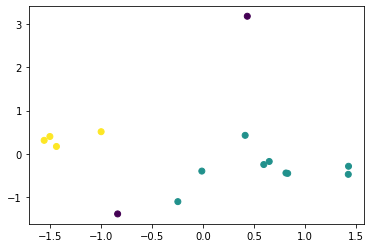

In [27]:
'''
Clustering of features using DBSCAN
'''
X = data[:, 0, :]
y = data[:, 1, :]
X, X_attrs, y, y_attrs = normalise(X, y)
dbs = DBSCAN(eps = 2.5, min_samples= 2).fit(X)
plt.scatter(X[:, 1], X[:, 4], c= dbs.labels_)

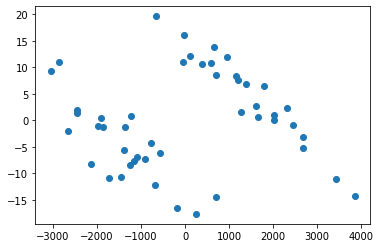

In [28]:
'''
PCA
'''
X = data[0, :, :]
pca = PCA()
pca = pca.fit_transform(X)
fig2 = plt.scatter(pca[:, 0], pca[:, 1])

C:\Apps\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Apps\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


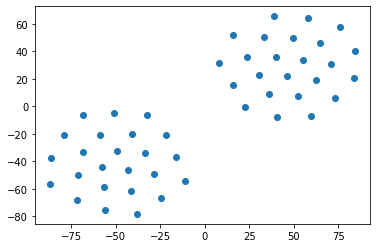

In [29]:
X = data[0, :, 2:]
y = data[0, :, 1]
tsne = TSNE()
X_embedded = tsne.fit_transform(X)
fig2 = plt.scatter(X_embedded[:, 0], X_embedded[:, 1])

In [30]:
# import ridge regression from sklearn library
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

# Y = gdp_df
X = data[0, :, 2:]
# Output : Productivity GDP
Y = data[0, :, 1]

X_norm = preprocessing.normalize(X)

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X_norm, Y, test_size=0.25, random_state=42)

# Train the model
ridgeR = Ridge(alpha = 1, normalize=True)
ridgeR.fit(x_train, y_train)
y_pred = ridgeR.predict(x_test)

# calculate mean square error
mean_squared_error_ridge = np.mean((y_pred - y_test)**2)
print(mean_squared_error_ridge)

x_train = pd.DataFrame(x_train)
# get ridge coefficient and print them
ridge_coefficient = pd.DataFrame()
ridge_coefficient["Columns"]= x_train.columns
ridge_coefficient['Coefficient Estimate'] = pd.Series(ridgeR.coef_)
ridge_coefficient


941.8428063590204


C:\Apps\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


,Columns,Coefficient Estimate
0,0,-453.680656
1,1,536.113454
2,2,-241.400853
3,3,167.263182
4,4,-21.304564
5,5,-267.873317
6,6,-16215.675272


In [31]:
# import Lasso regression from sklearn library
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn import preprocessing

X = data[0, :, 2:]
# Output : Productivity GDP
Y = data[0, :, 1]
X_norm = preprocessing.normalize(X)

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X_norm, Y, test_size=0.25, random_state=42)

# Train the model
lasso = Lasso(alpha = 1, normalize=True)
lasso.fit(x_train, y_train)
y_pred1 = lasso.predict(x_test)

# Calculate Mean Squared Error
mean_squared_error = np.mean((y_pred1 - y_test)**2)
print("Mean squared error on test set", mean_squared_error)

x_train = pd.DataFrame(x_train)
lasso_coeff = pd.DataFrame()
lasso_coeff["Columns"] = x_train.columns
lasso_coeff['Coefficient Estimate'] = pd.Series(lasso.coef_)

lasso_coeff


Mean squared error on test set 763.4234967756414


C:\Apps\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


,Columns,Coefficient Estimate
0,0,-1748.895381
1,1,0.000000
2,2,-127.243167
3,3,0.000000
4,4,0.000000
5,5,-0.000000
6,6,-0.000000


In [32]:
# evaluate an elastic net model on the dataset
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet
# load the dataset
X = data[0, :, 2:]
# Output : Productivity GDP
Y = data[0, :, 1]
# define model
model = ElasticNet(alpha=1.0, l1_ratio=0.5)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

[20.20251113 20.13322095 26.41031172 12.51154259 15.36927621 15.04312851
 11.90317292 14.99300994 16.62666659 23.15199596 10.14115242  9.33752818
 11.36589057 16.21335457 18.05064311 18.22839325 31.91334547 17.27941782
 20.76283294 21.81415476 15.01158079 20.50201196 19.37416029 18.48931382
 15.47534215 12.61895791 19.36748184 31.99906454 14.01398535  2.6140898 ]
Mean MAE: 17.364 (6.033)


In [33]:
''''''
# import model
from sklearn.linear_model import ElasticNet
# dfs = per_employee_df, per_HW_df + education_dfs +inf_df, unem_df, dep_quarterly_df
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing


# Input = [Country, Time, Feature]
X = data[0, :, 2:]
# Output : Productivity GDP
Y = data[0, :, 1]
X_norm = preprocessing.normalize(X)
# scaler = StandardScaler()
# x_scaled = scaler.fit_transform(X)

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X_norm, Y, test_size=0.25, random_state=42)
'''
x_train, x_test, y_train, y_test = train_test_split(
    df.iloc[:, :7], gdp_df.iloc[:,-1],
    test_size = 0.25, random_state=5)'''


# Train the model
e_net = ElasticNet(alpha = 1, normalize=True)
e_net.fit(x_train_scaled, y_train)
x_train = pd.DataFrame(x_train_scaled)
# calculate the prediction and mean square error
y_pred_elastic = e_net.predict(x_test_scaled)
mean_squared_error = np.mean((y_pred_elastic - y_test)**2)
print("Mean Squared Error on test set", mean_squared_error)
e_net_coeff = pd.DataFrame()
e_net_coeff["Columns"] = x_train.columns
e_net_coeff['Coefficient Estimate'] = pd.Series(e_net.coef_)
e_net_coeff

NameError: name 'x_train_scaled' is not defined